In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   

import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map

5j0n.mrc


NGLWidget()

In [3]:
file_name = './data/5j0n.mrc'

In [4]:
with mrcfile.open(file_name) as mrcVol:
    Vol      = np.array(mrcVol.data) 
    ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))


In [5]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [6]:
Projections = generate_projections_ASTRA(Vol, angles2, ProjSize, BatchSizeAstra = "None")
dtype = np.float32
Projections = np.array(Projections, dtype=dtype)

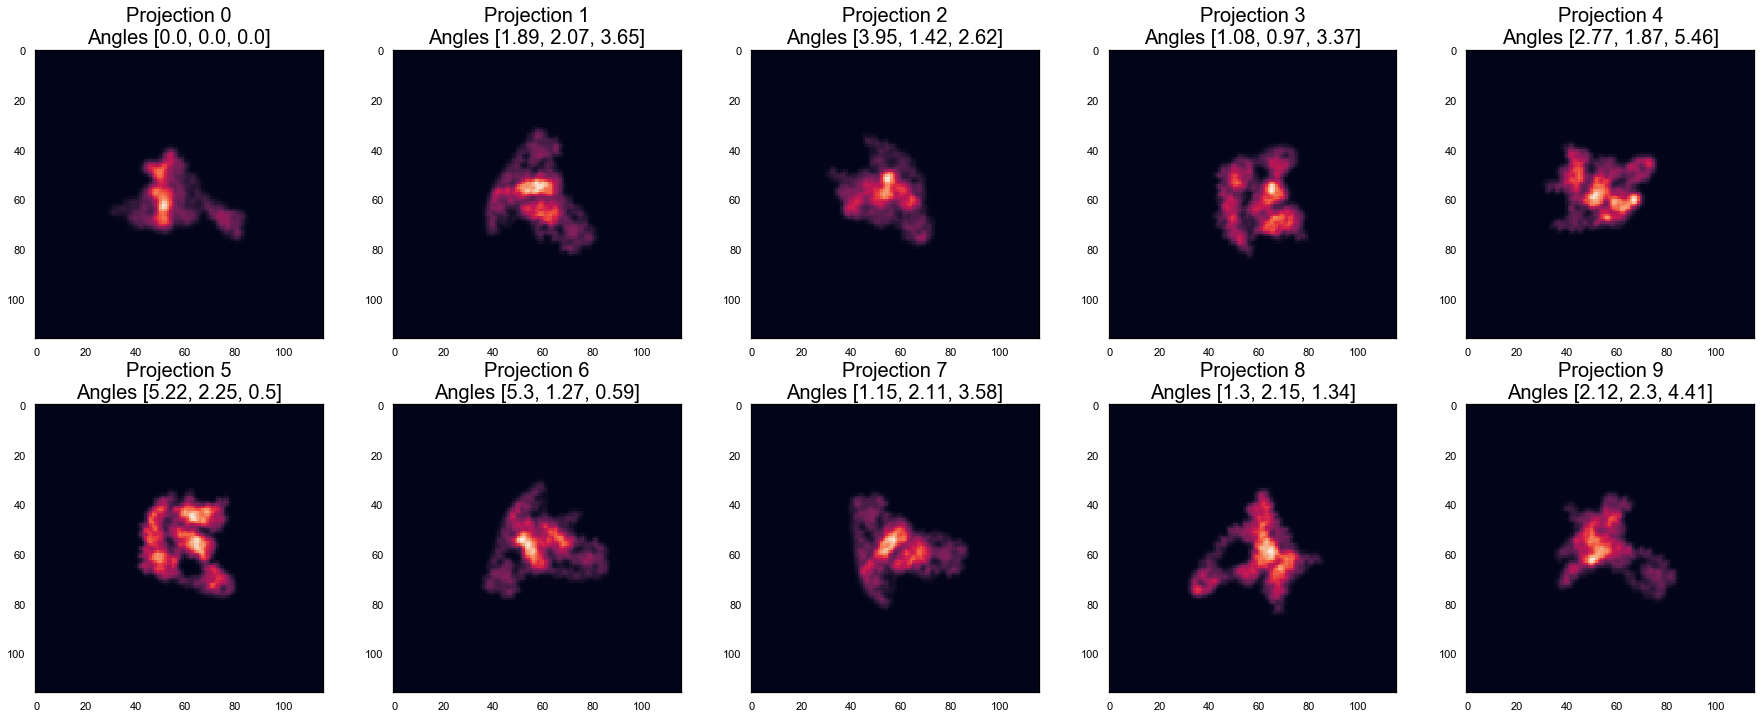

In [7]:
pids = range(10)
plot_projections(Projections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [8]:
BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [9]:
print(BP_data.shape)
print(BP_data[0].shape)
print(Projections[0].shape)
print(np.sum(BP_data[0] - Projections[0]))

(116, 116, 116)
(116, 116)
(116, 116)
586.9709


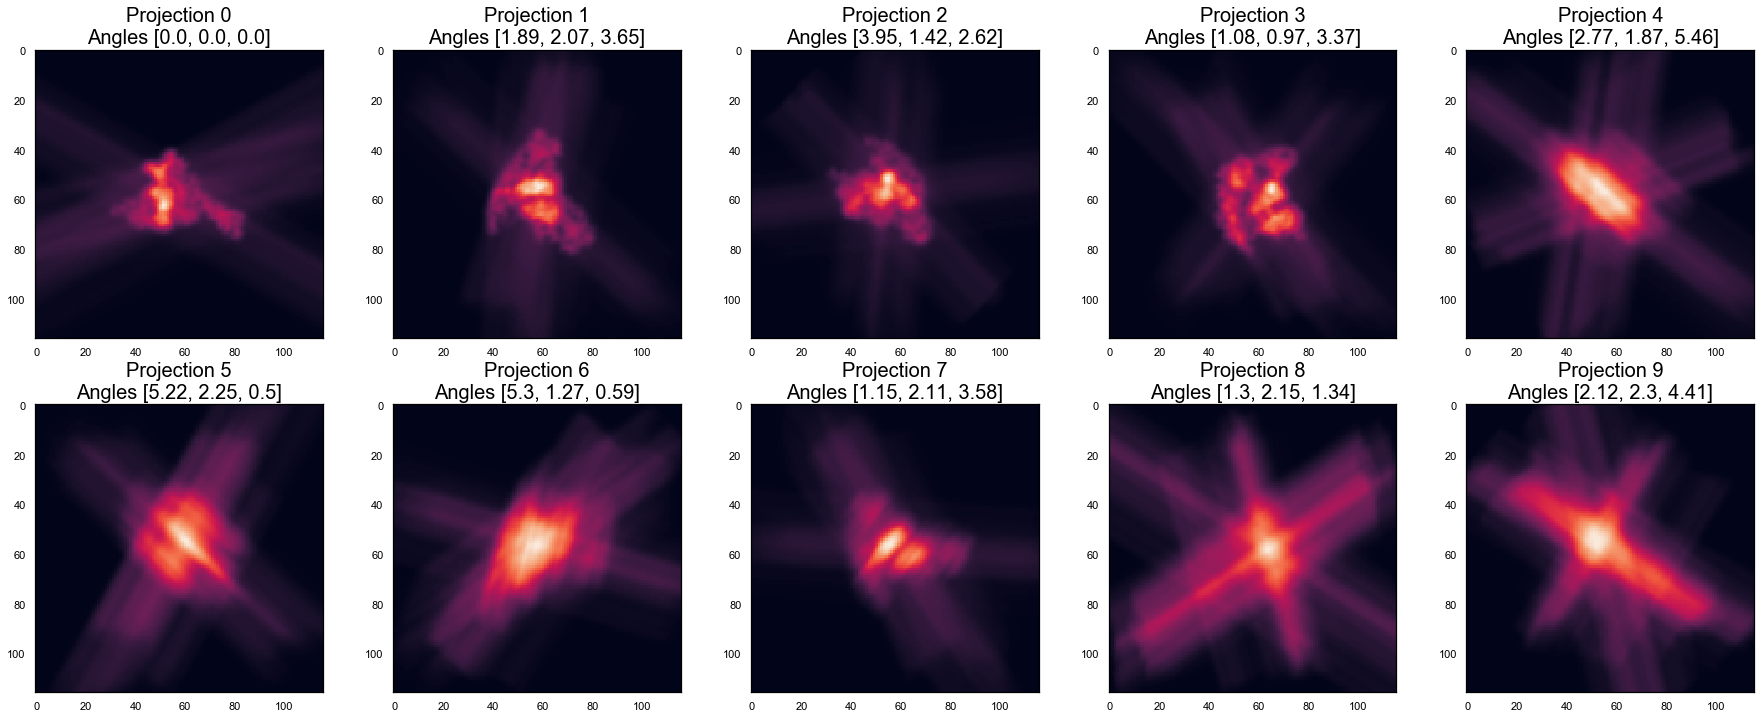

In [10]:
CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [13]:
class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.random.randn(ProjSize, ProjSize, ProjSize)
        self.sigma = np.random.randn(num_image)
    
    def fit(self, Imgages, Angles):
        self.ro, self.BigSigma = self.Expectation(Imgages, Angles)
        self.mu, self.sigma = self.Maximization(Imgages, Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        print(self.BigSigma[50])
        print(self.BigSigma.shape)
        
        
    def Maximization(self, Images, Angles):
        
        lr = 1e-9
        for i in range(100):
            DeltaMu = self.Delta_mu( Images, Angles)
            self.mu = self.mu - lr * DeltaMu
            self.Au_s(Angles)
            print('self.mu', np.sum(self.mu))
        #print(self.mu)
        pass
    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize)
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        print(Projections.shape)
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        
    def Au(self, Angles):
        """
        Only compute one Au
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        print(Projections.shape)
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
    
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1])
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q(self, )
        

In [14]:
ProjSize, num_image , n_component = 116, 5000 , 1
P3R = PCA_3d_Recon(ProjSize, num_image, n_component)
P3R.Au_s(angles2)
P3R.AtI(Projections[4], angles2[4])
print('Projections', Projections.shape)
P3R.Expectation(Projections, angles2)
P3R.Maximization(Projections, angles2)

(5000, 116, 116)
Projections (5000, 116, 116)
(5000, 116, 116)
[[3.28614694e-06]]
(5000, 1, 1)
(5000, 116, 116)
self.mu 1197.9144432323633
(5000, 116, 116)
self.mu 1313.5295748306808
(5000, 116, 116)
self.mu 1429.1519971571663
(5000, 116, 116)
self.mu 1544.7817104932162
(5000, 116, 116)
self.mu 1660.4187155092673
(5000, 116, 116)
self.mu 1776.0630121430152
(5000, 116, 116)
self.mu 1891.7146012316643
(5000, 116, 116)
self.mu 2007.3734831071063
(5000, 116, 116)
self.mu 2123.0396584935197
(5000, 116, 116)
self.mu 2238.713127789513
(5000, 116, 116)
self.mu 2354.393891497135
(5000, 116, 116)
self.mu 2470.081949572129
(5000, 116, 116)
self.mu 2585.7773025556985
(5000, 116, 116)
self.mu 2701.4799512911927
(5000, 116, 116)
self.mu 2817.1898962639075
(5000, 116, 116)
self.mu 2932.9071374741197
(5000, 116, 116)
self.mu 3048.6316758852313
(5000, 116, 116)
self.mu 3164.363511755614
(5000, 116, 116)
self.mu 3280.1026453842737
(5000, 116, 116)
self.mu 3395.849077568769
(5000, 116, 116)
self.mu 3511.

KeyboardInterrupt: 